#ch.5 트리 알고리즘 - 화이트 와인을 찾아라!

## 05-1 결정 트리

### 로지스틱 회귀로 와인 분류하기

In [2]:
import pandas as pd
wine = pd.read_csv('https://bit.ly/wine_csv_data')

# class는 타깃 데이터로, 0이면 레드 와인, 1이면 화이트 와인

In [ ]:
wine.head()

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


In [ ]:
wine.info()
# 누락된 값이 있는지 없는지 알 수 있음
# 누락된 값이 있다면? 그 데이터를 버리거나 평균값으로 채운 후에 사용할 수 있다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


In [ ]:
wine.describe()
# 열에 대한 간략한 통계 출력하기

,alcohol,sugar,pH,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501,0.753886
std,1.192712,4.757804,0.160787,0.430779
min,8.000000,0.600000,2.720000,0.000000
25%,9.500000,1.800000,3.110000,1.000000
50%,10.300000,3.000000,3.210000,1.000000
75%,11.300000,8.100000,3.320000,1.000000
max,14.900000,65.800000,4.010000,1.000000


In [3]:
target = wine['class'].to_numpy()
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()

In [4]:
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=42)
# test_size = 0.2라는 것은 샘플 개수가 지금처럼 충분히 많을 때에 20% 정도만 테스트 세트로 나누겠다는 것이다. 기본 값은 25%이다.

In [5]:
print(train_input.shape, test_input.shape)

(5197, 3) (1300, 3)


In [6]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

In [7]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_scaled, train_target)
print(lr.score(train_scaled, train_target))
print(lr.score(test_scaled, test_target))

0.7808350971714451
0.7776923076923077


- 결과 : 과소적합
- 해결 1) 규제 매개변수 C를 바꾸기
- 해결 2) solver 매개변수에서 다른 알고리즘 선택하기
- 해결 3) 다항 특성을 만들어서 추가하기

In [ ]:
print(lr.coef_, lr.intercept_)

[[ 0.51270274  1.6733911  -0.68767781]] [1.81777902]


### 결정 트리
- 이유를 설명하기 쉽도록
- DecisionTreeClassifier 클래스를 사용해 결정 트리 모델을 훈련한다.

In [8]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(train_scaled, train_target)
print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))
# 과대적합 모델

0.996921300750433
0.8592307692307692


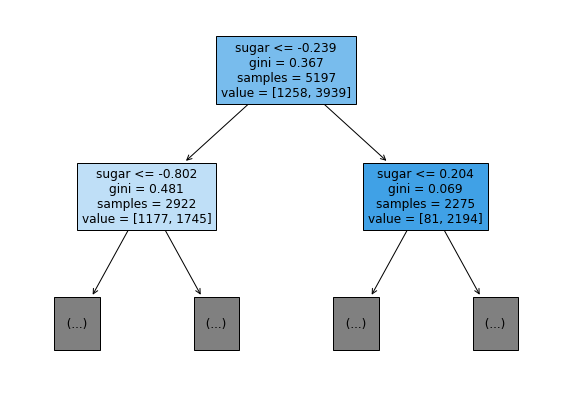

In [9]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(10, 7))
plot_tree(dt, max_depth=1, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
plt.show()

- 질문 : sugar <= -0.239
- 질문에 대한 답 : 왼쪽 - Yes, 오른쪽 - No
- 루트 노드의 총 샘플 수 : 5197개
- 클래스 당 와인 수 : 레드와인 1258개, 화이트와인 3939개
- gini : 지니 불순도 - 노드에서 데이터를 분할할 기준 정하기
  - sugar <= -0.239을 결정하도록 했음
  - 지니 불순도 = 1 - (음성클래스비율^2 + 양성클래스비율^2)
  - 노드에 하나의 클래스만 있다면 지니 불순도 값은 0이 된다. → 순수 노드
- 부모 노드와 자식 노드의 불순도 차이가 가능한 크도록 트리를 성장시킨다. (정보 이득이 최대가 되도록)
  - (부모 노드의 불순도) - (자식 노드의 불순도를 샘플 개수에 비례하여 더한 값)
  - 예) 왼쪽으로 2922개, 오른쪽으로 2275개 이동.
  - 0.367 - ((2922/5197) * 0.481 + (2275/5197) * 0.069) = 0.066

### 정리
- 결정 트리 모델은 부모 노드와 자식 노드의 불순도 차이를 최대로 만드는 방향으로 성장시킨다.
- 정보 이득 : 부모와 자식 노드의 불순도 차이
- 불순도 기준을 사용해 정보 이들이 최대가 되도록 노드를 분할한다.
- 노드를 순수하게 나눌수록 정보 이득이 커진다. (두 클래스의 개수 차이가 크도록)
- 새로운 샘플에 대해 예측할 때에는 노드의 질문에 따라 트리를 이동한다.
- 마지막에 도달한 노드의 클래스 비율을 보고 예측을 만든다.

### 가지치기
- 가지치기를 제대로 하지 않으면 훈련 세트에서는 아주 잘 맞겠지만, 테스트에서 점수는 그에 못 미칠 것임 (과대적합)
- 일반화가 잘 안 될 것이다.
- 자랄 수 있는 트리의 최대 깊이를 지정한다.

In [ ]:
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(train_scaled, train_target)
print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))
# 여전히 테스트 세트의 점수가 높지 않다.

0.8454877814123533
0.8415384615384616


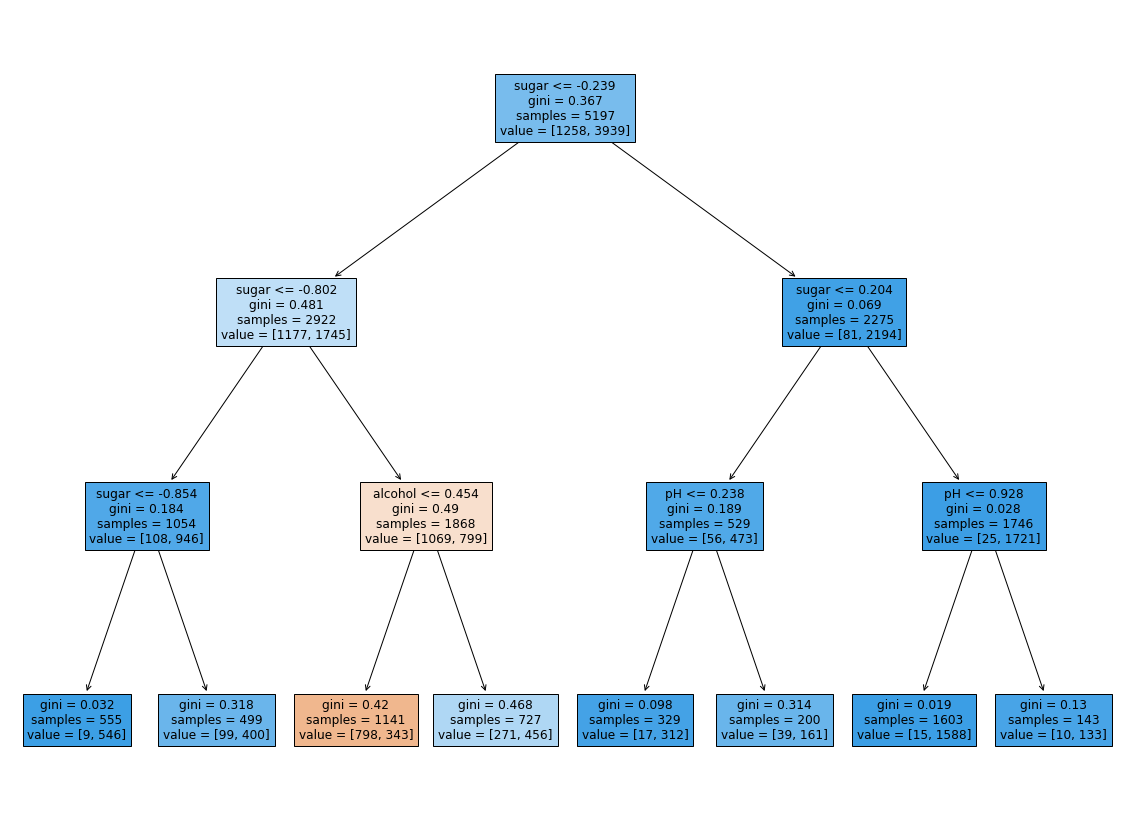

In [ ]:
plt.figure(figsize=(20, 15))
plot_tree(dt, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
plt.show()

- 리프 노드 중에서 왼쪽에서 세번째에 있는 노드만 음성 클래스가 더 많다. 즉, 그 노드에 도착해야지만 레드 와인으로 예측한다.
- -0.802 < 당도 <= -0.239
- 알코올 농도 <= 0.454
- 클래스 별 비율 → 불순도 → 샘플 나누기
- 전처리 과정 필요 없음. (StandardScaler)

In [ ]:
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(train_input, train_target)
print(dt.score(train_input, train_target))
print(dt.score(test_input, test_target))
# 전처리 전과 후가 결과가 같다.

0.8454877814123533
0.8415384615384616


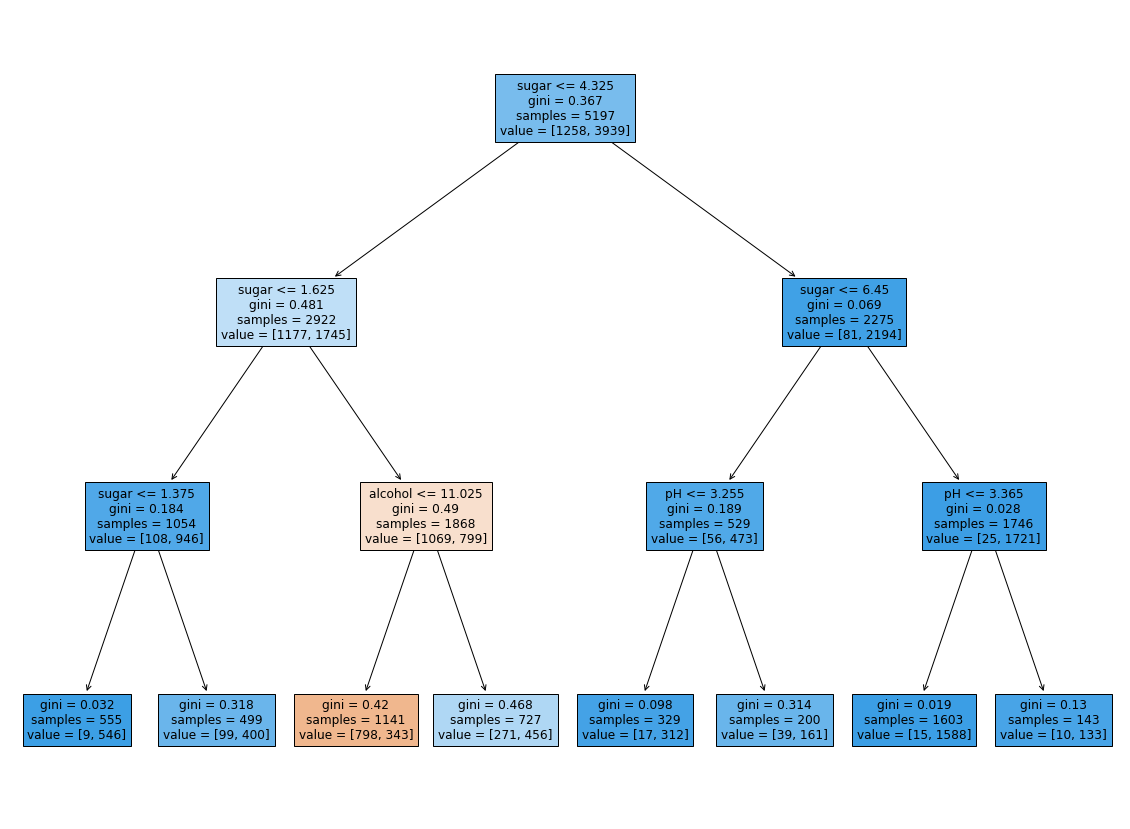

In [ ]:
plt.figure(figsize=(20, 15))
plot_tree(dt, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
plt.show()
# 전처리하기 전의 숫자이므로 당도가 음수가 나오지 않는다.

In [ ]:
# 특성 중요도 : 어떤 특성이 가장 유용한지 나타내줌
dt.feature_importances_

array([0.12345626, 0.86862934, 0.0079144 ])

0.8454877814123533
0.8415384615384616


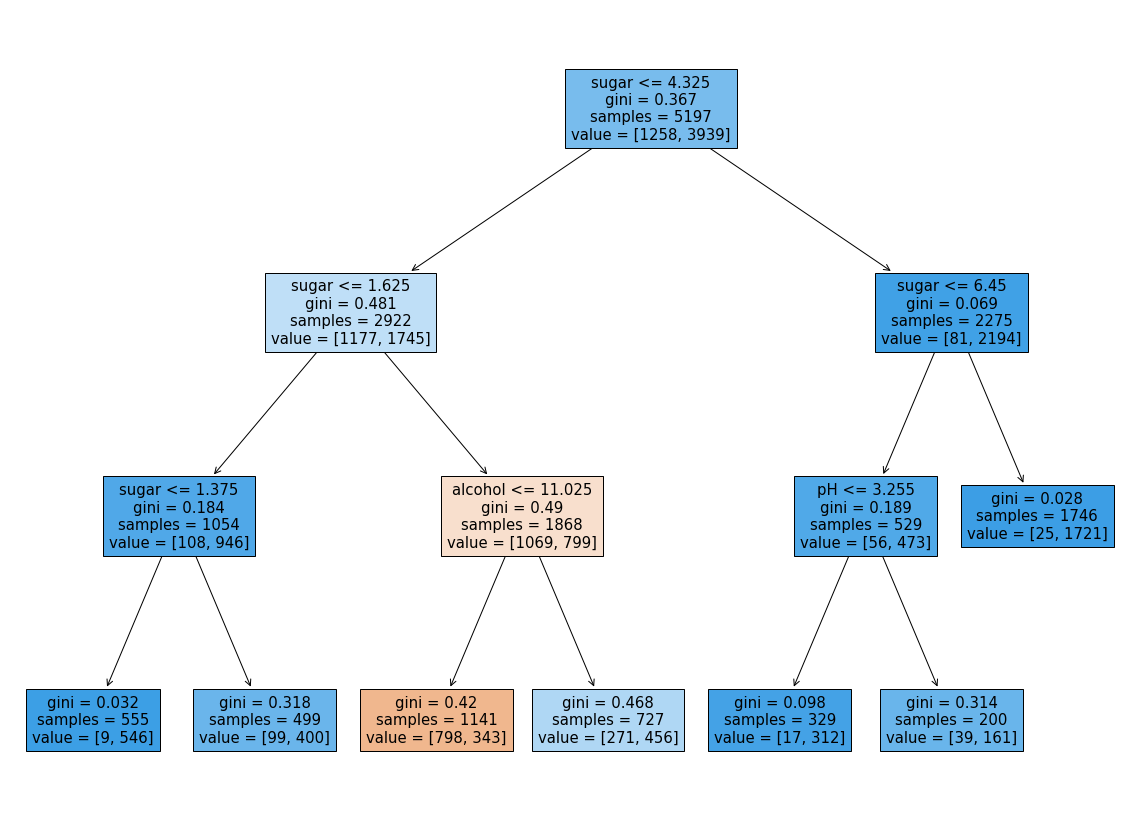

In [13]:
dt = DecisionTreeClassifier(max_depth=3, min_impurity_decrease=0.0005, random_state=42)
dt.fit(train_input, train_target)
print(dt.score(train_input, train_target))
print(dt.score(test_input, test_target))
plt.figure(figsize=(20, 15))
plot_tree(dt, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
plt.show()

## 05-2 교차 검증과 그리드 서치

###검증세트
- 모델을 여러개 만들어서 테스트 세트로 평가하면 결국은 테스트 세트에 잘 맞는 모델이 만들어지게 된다.
- 테스트 세트로 일반화 성능을 올바르게 예측하려면 가능한 한 테스트 세트를 사용하지 말아야 한다.
- 모델을 만들고 나서 마지막에 딱 한번만 사용하는 것이 좋다.
- 테스트 세트를 사용하지 않으면 모델이 과대적합인지 과소적합인지 판단하기 어렵다.
- **검증세트** : 훈련 세트를 또 나누어서 테스트한다.
- 보통 20 ~ 30%를 테스트 세트와 검증 세트로 떼어 놓는다. 단, 훈련 데이터가 아주 많다면 단 몇 %만 떼어놓아도 전체 데이터를 대표하는 데 문제가 없다.

In [15]:
import pandas as pd
wine = pd.read_csv('https://bit.ly/wine_csv_data')
wine.head()

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


In [18]:
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

In [19]:
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=42)

In [20]:
# train set 내부에서 test set를 또 나누기
sub_input, val_input, sub_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

In [21]:
print(train_input.shape)
print(sub_input.shape, val_input.shape)

(5197, 3)
(4157, 3) (1040, 3)


In [23]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(sub_input, sub_target)
print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target))
# 훈련세트에 과대적합 → 매개변수 바꿔서 더 좋은 모델 찾기

0.9971133028626413
0.864423076923077


### 교차 검증
- 검증 세트를 만드느라 훈련 세트가 줄어들었고, 이는 많은 데이터를 훈련에 사용하지 못하게 하여 좋은 모델이 될 수가 없게 된다.
- 검증 세트를 너무 조금 떼어 놓으면 검증 점수가 들쭉날쭉하고 불안정해진다.
- 교차 검증 : 검증 세트를 떼어 내어 평가하는 과정을 여러번 반복하여 점수를 평균으로 낸다. 평균값이 최종 검증 점수이다.
  - 예) 3-폴드 교차 검증 : 훈련 세트를 세 부분으로 나눠서 교차 검증을 수행한다.
- 주로 5-폴드 교차 검증이나 10-폴드 교차 검증을 많이 사용한다.

In [24]:
# cross_validate() 교차 검증 함수
from sklearn.model_selection import cross_validate
scores = cross_validate(dt, train_input, train_target)
print(scores)

{'fit_time': array([0.00983953, 0.00965405, 0.00968647, 0.01037073, 0.00967956]), 'score_time': array([0.00104856, 0.00101686, 0.00092578, 0.00091219, 0.00089979]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}


- fit_time : 모델을 훈련하는 시간
- score_time : 모델을 검증하는 시간
- test_score : 검증 폴드의 점수

In [25]:
import numpy as np
print(np.mean(scores['test_score']))

0.855300214703487


- cross_validate()는 훈련 세트를 섞어 폴드를 나누지 않는다.
- train_test_split()은 전체 데이터를 섞은 후 훈련 세트를 준비했음
- 교차 검증은 훈련 세트를 섞으려면 분할기 (spliter)를 지정해야 한다.
- 기본적으로 회귀모델에서는 KFold 분할기를, 분류 모델에서는 StratifiedKFold를  사용한다

In [26]:
from sklearn.model_selection import StratifiedKFold
scores = cross_validate(dt, train_input, train_target, cv=StratifiedKFold())
print(np.mean(scores['test_score']))

0.855300214703487


In [27]:
# 훈련 세트를 섞은 후 10-폴드 교차 검증 수행
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_validate(dt, train_input, train_target, cv=splitter)
print(np.mean(scores['test_score']))

0.8574181117533719


### 하리퍼파라미터 튜닝
- 모델 파라미터 : 머신러닝 모델이 학습하는 파라미터
- 하이퍼 파라미터 : 머신러닝 모델이 학습할 수 없어서 사용자가 지정해야만 하는 파라미터
  - 사이킷런에서 하이퍼파라미터는 클래스나 메서드의 매개변수로 표현된다.
- 하이퍼파라미터 튜닝 : 라이브러리가 제공하는 기본값을 그대로 사용해 모델을 훈련한 후, 매개변수를 바꿔가면서 모델을 훈련하고 교차 검증을 수행한다.
  - 한 매개변수의 최적값을 찾고 다른 매개변수의 최적값을 찾으면 안된다.
  - 두 매개변수를 동시에 바꿔가며 최적의 값을 찾아야 한다.
- 사이킷런에서 제공하는 그리드 서치 (Grid Search)를 사용한다.
  - 하이퍼파라미터 탐색과 교차 검증을 한 번에 수행한다.
  - 별도로 cross_validate() 함수를 호출할 필요가 없다.

In [28]:
# min_impurity_decrease 매개변수의 최적값 찾기
from sklearn.model_selection import GridSearchCV
params = {'min_impurity_decrease': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}

In [29]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
# n_jobs는 CPU 코어 수를 지정하는 것. -1이면 시스템에 있는 모든 코어를 사용한다.
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'min_impurity_decrease': [0.0001, 0.0002, 0.0003,
                                                   0.0004, 0.0005]})

- 교차 검증에서 최적의 하이퍼파라미터를 찾으면 전체 훈련 세트로 모델을 다시 만들어야 한다.
- 그리드 서치는 훈련이 끝나면 25개의 모델 중에서 검증 점수가 가장 높은 모델의 매개변수 조합으로 전체 훈련 세트에서 자동으로 다시 모델을 훈련한다.
- 이 모델은 gs 객체의 best_estimator_ 속성에 저장되어 있다.

In [32]:
dt = gs.best_estimator_
print(dt.score(train_input, train_target))
print(gs.best_params_)
print(gs.cv_results_['mean_test_score'])

0.9615162593804117
{'min_impurity_decrease': 0.0001}
[0.86819297 0.86453617 0.86492226 0.86780891 0.86761605]


In [34]:
best_index = np.argmax(gs.cv_results_['mean_test_score'])
print(gs.cv_results_['params'][best_index])

{'min_impurity_decrease': 0.0001}


### 과정 정리
1. 먼저 탐색할 매개변수를 지정한다.
2. 훈련 세트에서 그리드 서치를 수행하여 최상의 평균 점수가 나오는 매개변수 조합을 찾는다. 이 조합은 그리드 서치 객체에 저장된다.
3. 그리드 서치는 최상의 매개변수에서 전체 훈련 세트를 사용해 최종 모델을 훈련한다. 이 모델은 그리스 서치 객체에 저장된다.

In [38]:
# min_impurity_decrease 지정하고 max_depth로 트리 높이를 제한하고 min_samples_split으로 노드를 나누기 위한 최소 샘플 수도 고른다.
params = {'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001),
          'max_depth': range(5, 20, 1),
          'min_samples_split': range(2, 100, 10)
          }
# 총 9개 * 15개 * 10개 = 1350개
# 기본 5-폴드 교차 검증 : 1350개 * 5 = 6758개

In [40]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
gs.fit(train_input, train_target)
print(gs.best_params_)

{'max_depth': 14, 'min_impurity_decrease': 0.0004, 'min_samples_split': 12}


In [42]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8683865773302731


### 랜덤서치
- 매개변수의 값이 수치일 때, 값의 범위나 간격을 미리 결정하기 어려울 수 있다.
- 너무 많은 매개변수 조건이 있어서 서치 수행 시간이 오래 걸릴 수 있다.
- 랜덤서치 : 매개변수 값의 목록을 전달하는 것이 아니라 매개변수를 샘플링할 수 있는 확률 분포 객체를 전달한다.

In [44]:
# 주어진 범위에서 고르게 값을 뽑는다. [ 균등 분포에서 샘플링 ]
# uniform : 실수값 뽑기 / randint : 정수값 뽑기
from scipy.stats import uniform, randint
rgen = randint(0, 10)
rgen.rvs(10)


array([3, 3, 4, 1, 0, 0, 7, 1, 2, 0])

In [45]:
np.unique(rgen.rvs(1000), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 88, 107, 101,  97,  99, 107, 100,  94, 100, 107]))

In [46]:
ugen = uniform(0, 1)
ugen.rvs(10)

array([0.64258471, 0.4276015 , 0.16247408, 0.90272966, 0.00788142,
       0.45285931, 0.91073525, 0.23975126, 0.35777255, 0.96221592])

In [47]:
params = {'min_impurity_decrease': uniform(0.0001, 0.001),
          'max_depth': randint(20, 50),
          'min_samples_split': randint(2, 25),
          'min_samples_leaf': randint(1, 25),
          }

In [48]:
from sklearn.model_selection import RandomizedSearchCV
gs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params, n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fcf2a8c0810>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fcf2a8d2850>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fcf2a8c0350>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fcf2b02fad0>},
                   random_state=42)

In [49]:
print(gs.best_params_)

{'max_depth': 39, 'min_impurity_decrease': 0.00034102546602601173, 'min_samples_leaf': 7, 'min_samples_split': 13}


In [50]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8695428296438884


In [51]:
dt = gs.best_estimator_
print(dt.score(test_input, test_target))

0.86


In [52]:
# splitter='random' 매개변수 추가하고 훈련해보기
gs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42, splitter='random'), params, n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)
print(gs.best_params_)
print(np.max(gs.cv_results_['mean_test_score']))
dt = gs.best_estimator_
print(dt.score(test_input, test_target))

{'max_depth': 43, 'min_impurity_decrease': 0.00011407982271508446, 'min_samples_leaf': 19, 'min_samples_split': 18}
0.8458726956392981
0.786923076923077


## 05-3 트리의 앙상블

### 정형 데이터와 비정형 데이터
- 정형 데이터 : 어떤 구조로 되어 있음
  - csv, 데이터베이스, 엑셀
- 비정형 데이터 : 데이터베이스나 엑셀로 표현하기 어려운 것들
  - 텍스트 데이터, 사진, 디지털 음악
- 텍스트나 사진을 데이터베이스에 저장할 수도 있다.
  - NoSQL 데이터베이스는 엑셀이나 CSV에 담기 어려운 텍스트나 JSON 데이터를 저장하는 데 용이하다.
  - cf) 비정형 데이터는 신경망 알고리즘으로 모델을 만든다.


### 랜덤 포레스트
- 앙상블 학습 알고리즘 : 사이킷런에서 제공하는 정형 데이터를 다루는 데 가장 뛰어난 성과를 내는 알고리즘으로 대부분 결정 트리를 기반으로 만들어져 있다.
- 앙상블 학습을 적용할 때 가장 먼저 랜덤 포레스트를 시도해보아야 한다.
- 트리는 계속해서 훈련하면 과대적합이 된다. 그만큼 성능이 좋아진다는 뜻이다. 
- 랜덤 포레스트는 결정 트리를 랜덤하게 만들어 결정 트리의 숲을 만든다.
- 그 후, 각 결정 트리의 예측을 사용해 최종 예측을 만든다.
- 분류 : 각 트리에서 클래스 별로 확률을 구하고 확률을 다 더한 후에 트리 개수로 나눈다.
- 회귀 : 각 트리마다 예측값을 구하고 평균 낸다.

### 부트스트랩 샘플
- 각 트리를 훈련하기 위한 데이터를 랜덤하게 만드는데, 우리가 입력한 훈련 데이터에서 랜덤하게 샘플을 추출하여 훈련 데이터를 만든다.
- 한 샘플이 중복되어 추출될 수도 있다.
- 100개 중에서 10개를 골라 훈련 데이터를 만든다고 할 때, 1개의 샘플을 고르고 그 샘플을 다시 99개가 들어있는 곳에 넣어서 다시 100개 중에서 1개를 뽑는다. 이러한 행동을 10회 반복한다.
- 부트스트랩 샘플은 훈련 세트의 크기와 같다.
- 부트스트랩 방식 : 데이터 세트에서 중복을 허용하여 데이터를 샘플링하는 방식 


### RandomForestClassifier (분류)
- 각 노드를 분할할 때 전체 특성 중에서 일부 특성을 무작위로 고르는데, 특성의 개수는 전체 특성 개수의 루트값 만큼이다. (4개의 특성이 있다면 2개를 랜덤하게 선택)
- 무작위성을 제공하여 최적의 분할을 하는 것을 방해한다.
- 트리가 성능이 너무 좋아져서 과대적합되는 것을 방지한다.

### RandomForestRegressor (회귀)
- 전체 특성을 사용한다.


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
wine = pd.read_csv('https://bit.ly/wine_csv_data')
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()
train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=42)

In [5]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1, random_state=42)
scores = cross_validate(rf, train_input, train_target, return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9973541965122431 0.8905151032797809


In [8]:
# 결정트리 알고리즘으로 학습시키기
rf.fit(train_input, train_target)
# 결정 트리의 장점 : 특성 중요도 계산
print(rf.feature_importances_)  # 당도가 가장 중요한 특성이 되었음

[0.23167441 0.50039841 0.26792718]


- 랜덤 포레스트가 특성의 일부를 랜덤하게 선택하여 결정 트리를 훈련했고, 그 결과 하나의 특성에 집중하지 않고 좀 더 많은 특성이 훈련에 기여할 기회를 얻었다.
- 이는 과대적합을 줄이고 일반화 성능을 높이는 데 도움이 된다.

- 자체적으로 모델 평가하는 점수 얻기
- OOB (Out of Bag) 샘플 : 부트스트랩 샘플에 포함되지 않고 남는 샘플 
- OOB 샘플로 부트스트랩 샘플로 훈련한 결정 트리를 평가할 수 있다. (검증 세트의 역할)

In [11]:
rf = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=42)
rf.fit(train_input, train_target)
print(rf.oob_score_)

0.8934000384837406


### 엑스트라 트리
- 랜덤 포레스트와 매우 비슷하게 동작한다.
- 결정 트리를 만들 때 전체 훈련 세트를 사용한다.
- 대신, 노드를 분할할 때 가장 좋은 분할을 찾는 것이 아니라 무작위로 분할한다.
- 많은 트리를 앙상블함으로써 과대적합ㅇㄹ 막고 검증 세트의 점수를 높인다.
- splitter='random'인 결정 트리

In [12]:
from sklearn.ensemble import ExtraTreesClassifier
et = ExtraTreesClassifier(n_jobs=-1, random_state=42)
scores = cross_validate(et, train_input, train_target, return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9974503966084433 0.8887848893166506


- 보통 엑스트라 트리가 무작위성이 더 크기 때문에 랜덤 포레스트보다 더 많은 결정 트리를 훈련해야 한다.
- 랜덤하게 노드를 분할하기 때문에 빠른 계산 속도가 엑스트라 트리의 장점이다.

In [13]:
et.fit(train_input, train_target)
print(et.feature_importances_)

[0.20183568 0.52242907 0.27573525]


### 그래디언트 부스팅
- 깊이가 얕은 결정 트리를 사용하여 이전 트리의 오차를 보완하는 방식으로 앙상블 하는 방식
- 기본적으로 깊이가 3인 결정 트리 100개를 사용한다.


In [16]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=42)
scores = cross_validate(gb, train_input, train_target, return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))
# 과대적합에 매우 강하다.

0.8881086892152563 0.8720430147331015


In [17]:
gb = GradientBoostingClassifier(n_estimators=500, learning_rate=0.2, random_state=42)
scores = cross_validate(gb, train_input, train_target, return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))
# 결정 트리 개수를 500개로 늘렸지만 과대적합을 잘 억제하고 있다.

0.9464595437171814 0.8780082549788999


- 트리 훈련에 사용할 훈련 세트의 비율을 정하는 subsample 매개변수의 기본값이 1.0으로 전체 훈현 세트를 사용한다.
- 하지만, subsample이 1보다 작으면 경사 하강법처럼 일부 샘플을 랜덤하게 선택하여 진행하는 확률적 / 미니배치와 비슷해진다.
- 그래디언트는 랜덤 포레스트보다 성능이 조금 더 높다.
- 하지만, 순서대로 트리를 추가하기 때문에 훈련 속도가 느리다.
- 병렬적으로 처리해주는 n_jobs 매개변수가 존재하지 않는다.

### 히스토그램 기반 그레이디언트 부스팅
- 속도와 성능을 더욱 개선했다.
- 정형 데이터를 다루는 머신러닝 알고리즘 중에서 가장 인기가 높은 알고리즘이다.
- 입력 특성을 256개의 구간으로 나눈다.
- 255개 + 1개 (누락된 값을 위한 구간)
- 기본 매개변수에서 안정적인 성능을 얻을 수 있다.


In [18]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
hgb = HistGradientBoostingClassifier(random_state=42)
scores = cross_validate(hgb, train_input, train_target, return_train_score=True)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

/usr/local/lib/python3.7/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


0.9321723946453317 0.8801241948619236


In [20]:
from sklearn.inspection import permutation_importance

hgb.fit(train_input, train_target)
result = permutation_importance(hgb, train_input, train_target, n_repeats=10, random_state=42, n_jobs=-1)
print(result.importances_mean)

[0.08876275 0.23438522 0.08027708]


- 히스토그램 기반 그레이디언트 부스팅의 특성 중요도 계산 : permutation_importance()
- 특성을 하나씩 랜덤하게 섞어서 모델의 성능이 변화하는지를 관찰하여 어떤 특성이 중요한지를 계산한다.
- n_repeats는 랜덤하게 섞을 횟수를 지정한다.

In [22]:
from sklearn.inspection import permutation_importance
hgb.fit(train_input, train_target)
result = permutation_importance(hgb, train_input, train_target, n_repeats=10, random_state=42, n_jobs=-1)
print(result.importances_mean)

[0.08876275 0.23438522 0.08027708]


In [23]:
result = permutation_importance(hgb, test_input, test_target, n_repeats=10, random_state=42, n_jobs=-1)
print(result.importances_mean)

[0.05969231 0.20238462 0.049     ]


In [24]:
hgb.score(test_input, test_target)

0.8723076923076923